# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 5 ноября 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 5 ноября, -4 балла после 06:00 12 ноября, -6 баллов после 06:00 19 ноября  -8 баллов после 06:00 26 ноября.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 2] Фамилия Имя.<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Решение***
$$Q*(\vec{w}) = \frac{1}{m}\left \| X\vec{w} - \vec{y} \right \|^{2} + \frac{1}{C}\left \| \vec{w} \right \|^{2},$$
где X - матрица признаков из мини-батча размера m на D (m - размер батча, D - число признаков)

$$\left \| X\vec{w} - \vec{y} \right \|^{2} = \left ( X\vec{w} - \vec{y}, X\vec{w} - \vec{y} \right ) = \left ( X\vec{w} \right )^{T}\left ( X\vec{w} - 2*\vec{y} \right ) + \left \| \vec{y} \right \|$$

Тогда производная принимает вид:
$$\nabla_{w}Q*(\vec{w}) = \frac{2}{m}\left ( X^{T}\left ( X\vec{w} - \vec{y} \right ) \right ) + \frac{2}{C}\vec{w}$$
$$\nabla_{w_k}Q*(\vec{w}) = \frac{2}{m}\sum_i \left [ a_i - y_i \right ]x_k^{i} + \frac{2}{C}w_k$$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Решение***
$$Q*(\vec{w}) = -\frac{1}{m}\sum_i \left[ y_i\log a_i + (1 - y_i)\log (1 - a_i) \right] + \frac{1}{C}\left \| \vec{w} \right \|^{2}$$
$$a_i = \sigma( \langle\,x_i,\vec{w}\rangle )$$
Отметим следующее:
$$\sigma(z) = \frac{1}{1 + \exp(-z)}$$
$${\sigma(z)}' = \frac{\exp(-z)}{(1 + \exp(-z))^{2}} = \sigma(z)*(1 - \sigma(z))$$
Тогда производная принимает вид:
$$\nabla_{w_k}Q*(\vec{w}) = -\frac{1}{m}\sum_i \left[ \frac{y_i}{a_i} - \frac{1 - y_i}{1 - a_i} \right] {\sigma}'( \langle\,x_i,\vec{w}\rangle )x_k^{i} + \frac{2}{C}w_k$$
$$= -\frac{1}{m}\sum_i \left[ y_i(1 - a_i) - (1 - y_i)a_i \right]x_k^{i} + \frac{2}{C}w_k$$
$$= -\frac{1}{m}\sum_i \left[ y_i(y_i - a_i) + (1 - y_i)(y_i - a_i) \right]x_k^{i} + \frac{2}{C}w_k$$
$$= \frac{1}{m}\sum_i \left[ a_i - y_i \right]x_k^{i} + \frac{2}{C}w_k$$
Отличие от формулы линейной регрессии в множителе перед первым слагаемым и способе рассчета $a_i$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Решение***
$$Q(\vec{w}) = \frac{1}{n}\left \| X\vec{w} - \vec{y} \right \|^{2} + \frac{1}{C}\left \| \vec{w} \right \|^{2},$$
$$\nabla_{w}Q(\vec{w}) = \frac{2}{n}\left ( X^{T}\left ( X\vec{w} - \vec{y} \right ) \right ) + \frac{2}{C}\vec{w}$$

Тогда градиент обращается в ноль при:
$$\vec{w} = (X^{T}X + \frac{n}{C}I)^{-1}X^{T}Y$$

Чем это хорошо: матрица, которая обращается в формуле точного решения, невырождена тогда, когда $\frac{n}{C}$ является собственным значением матрицы $X^{T}X$

Достаточное условия для минимума экстремума - положительная определенность Гессиана - матрицы вторых производных:

$$\nabla_{w}^{2}Q(\vec{w}) = X^{T}X$$
То есть это симметричная матрица => и положительно определенная

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Решение***

Возьмем производную мат.ожидания по параметру $a(x)$:
$$= -\frac{p(y_i = 1 |x_i )}{a(x_i)} + \frac{p(y_i = 0 | x_i)}{1 - a(x_i)}$$

Эта производная обращается в ноль при:
$$p(y_i = 1 |x_i )(1 - a(x_i)) = (1 - p(y_i = 1 |x_i ))a(x_i)$$
$$p(y_i = 1 |x_i ) = a(x_i)$$

И эта точка действительно минимум, так как производная в ней сменяет знак с минуса на плюс (при $a(x_i)$ меняющейся от 0 до 1 значение функции монотонно меняется от -inf до +inf)

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Решение***

Цель регуляризации - урезать слишком большие веса, отвечающие реальным признакам, и тем самым минимизировать переобучения на обучающих данных.

$w_0$ же - предсказание, не зависящее от признаков. Соответственно, проблема переобучения с ней не стоит.

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
%%pycodestyle

from itertools import zip_longest


def list_of_lists(a, size):
    """
    Генератор подсписков длины size, составляющих список a
    Длина последнего генерируемого списка может быть меньше size
    """

    for i, j in zip_longest(range(0, len(a), size),
                            range(size, len(a) + 1, size),
                            fillvalue=len(a)):
        yield a[i:j]

16:1: W391 blank line at end of file


In [7]:
%%pycodestyle


def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """

    if shuffle is True:
        indices = np.random.permutation(len(y))
    else:
        indices = np.arange(len(y))

    for indx_slice in list_of_lists(indices, batch_size):
        X_batch = X[indx_slice]
        y_batch = y[indx_slice]

        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
# my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

27:1: W391 blank line at end of file


In [8]:
%%pycodestyle

from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """

    sigm_value_x = 1.0/(1.0 + np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01,
                 max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        if self.model_type == 'lin_reg':
            loss = ((self.get_scalar(X_batch) - y_batch)**2).mean()
        else:
            p = sigmoid(self.get_scalar(X_batch))
            loss = -(np.dot(1.0 - y_batch, np.log(1.0 - p)) +
                     np.dot(y_batch, np.log(p))) / len(y_batch)

        loss += (self.weights[1::]**2).sum() / self.C

        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        a = self.get_scalar(X_batch)
        if self.model_type == 'log_reg':
            a = sigmoid(a) - y_batch
        else:
            a = 2*(a - y_batch)

        loss_grad = np.zeros_like(self.weights)
        loss_grad[0] = a.mean()
        loss_grad[1::] = (a@X_batch / len(y_batch) +
                          2*self.weights[1::] / self.C)

        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """

        self.weights -= self.alpha*new_grad

    def fit(self, X, y, shuffle=True, batch_size=1):
        '''s
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        # Добавляем фиктивный признак, тождественно равный единице:
        # Решил попробовать обойтись без этого
        # X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))
        # Инициализируем веса:
        # self.weights = np.zeros(X.shape[1] + 1)
        # self.weights = np.random.rand(X.shape[1] + 1)
        self.weights = np.ones(X.shape[1] + 1)/(X.shape[1]*10)

        for n in range(0, self.max_epoch):
            print('{0}{1} of {2}'.format(n//10, n % 10,
                                         self.max_epoch), end='\r')

            new_epoch_gen = self.batch_generator(X, y, shuffle, batch_size)
            for batch_num, new_batch in enumerate(new_epoch_gen):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_loss = self.calc_loss(X_batch, y_batch)

                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)

                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
            # self.alpha /= 4.0
        print('                     ', end='\r')

        return self

    def predict(self, X, h=0.5):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''

        y_hat = self.get_scalar(X)
        if self.model_type == 'log_reg':
            y_hat = sigmoid(y_hat) > h
        return y_hat

    def get_scalar(self, X):
        return X@self.weights[1::] + self.weights[0]


132:1: W391 blank line at end of file


Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [16]:
%%pycodestyle


def plot_decision_boundary(w, X):

    print(*w)

    x1min, x1max = X[:, 0].min(), X[:, 0].max()
    x2min, x2max = X[:, 1].min(), X[:, 1].max()

    if np.abs(w[1])*(x1max - x1min) > np.abs(w[2])*(x2max - x2min):
        x2 = np.array([x2min, x2max])
        x1 = -(w[2]*x2 + w[0])/w[1]
    else:
        x1 = np.array([x1min, x1max])
        x2 = -(w[1]*x1 + w[0])/w[2]

    plt.plot(x1, x2)

19:1: W391 blank line at end of file


-0.7676809629022763 0.25049950944413973 -0.05884147163108601
accuracy = 0.8225
loss = 0.5885085178723093


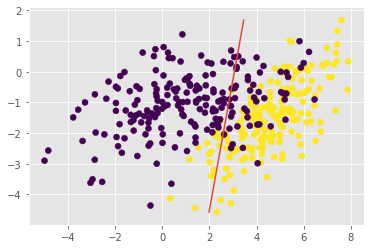

In [15]:
# %%pycodestyle

np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf = MySGDClassifier(batch_generator, model_type='log_reg')
clf.fit(X, y)
plot_decision_boundary(clf.weights, X)

print('accuracy =', (clf.predict(X) == y).mean())
print('loss =', clf.calc_loss(X, y))

plt.scatter(X[:, 0], X[:, 1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [11]:
from sklearn.datasets import make_classification

In [12]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

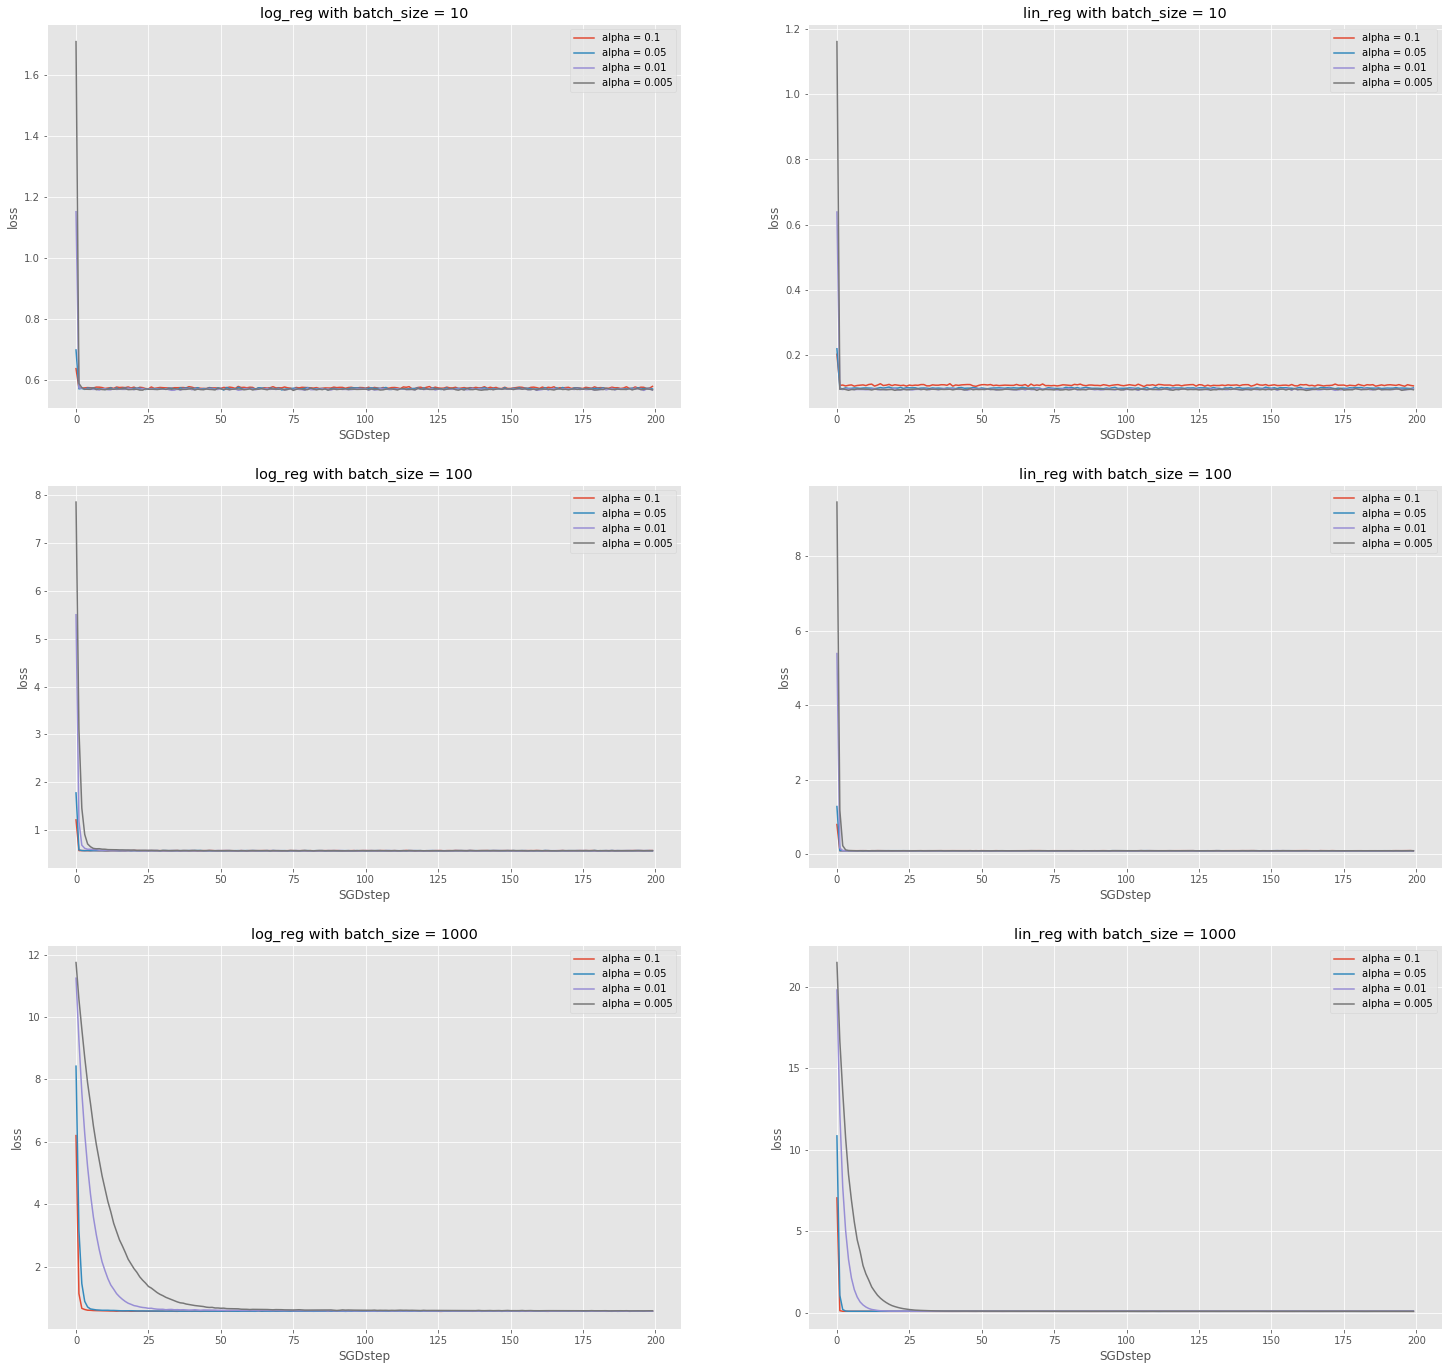

In [20]:
# %%pycodestyle

bs_list = (10, 100, 1000)
alpha_list = (0.1, 0.05, 0.01, 0.005)

fig = plt.figure(figsize=(25, 8*len(bs_list)))

for i, bs in enumerate(bs_list):
    ax = fig.add_subplot(100*len(bs_list) + 21 + i*2,
                         xlabel='SGDstep', ylabel='loss',
                         title='log_reg with batch_size = ' + str(bs))
    for al in alpha_list:
        clf = MySGDClassifier(batch_generator, alpha=al, model_type='log_reg')
        clf.fit(X, y, batch_size=bs)

        N = 5000//bs
        plt.plot([sum(sample)/len(sample)
                  for sample in list_of_lists(clf.errors_log['loss'], N)],
                 label=f'alpha = {al}')
    ax.set_ylim(auto=True)
    ax.legend()

    ax = fig.add_subplot(100*len(bs_list) + 22 + i*2,
                         xlabel='SGDstep', ylabel='loss',
                         title='lin_reg with batch_size = ' + str(bs))
    for j, al in enumerate(alpha_list):
        clf = MySGDClassifier(batch_generator, alpha=al, model_type='lin_reg')
        clf.fit(X, y, batch_size=bs_list[i])

        N = 5000//bs
        plt.plot([sum(sample)/len(sample)
                  for sample in list_of_lists(clf.errors_log['loss'], N)],
                 label=f'alpha = {al}')
    ax.legend()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Чем больше альфа, тем быстрее сходимоть. Но в то же время слишком большое значение брать не стоит - обновления весов на каждом батче будет слишком далеко отходить от общего курса. Лучшие значения в районе 0.01-0.1

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

1000.0
215.44346900318845   
46.4158883361278     
10.0                 
2.1544346900318843   
0.4641588833612782   
0.1                  
0.021544346900318867 
0.004641588833612782 
0.001                


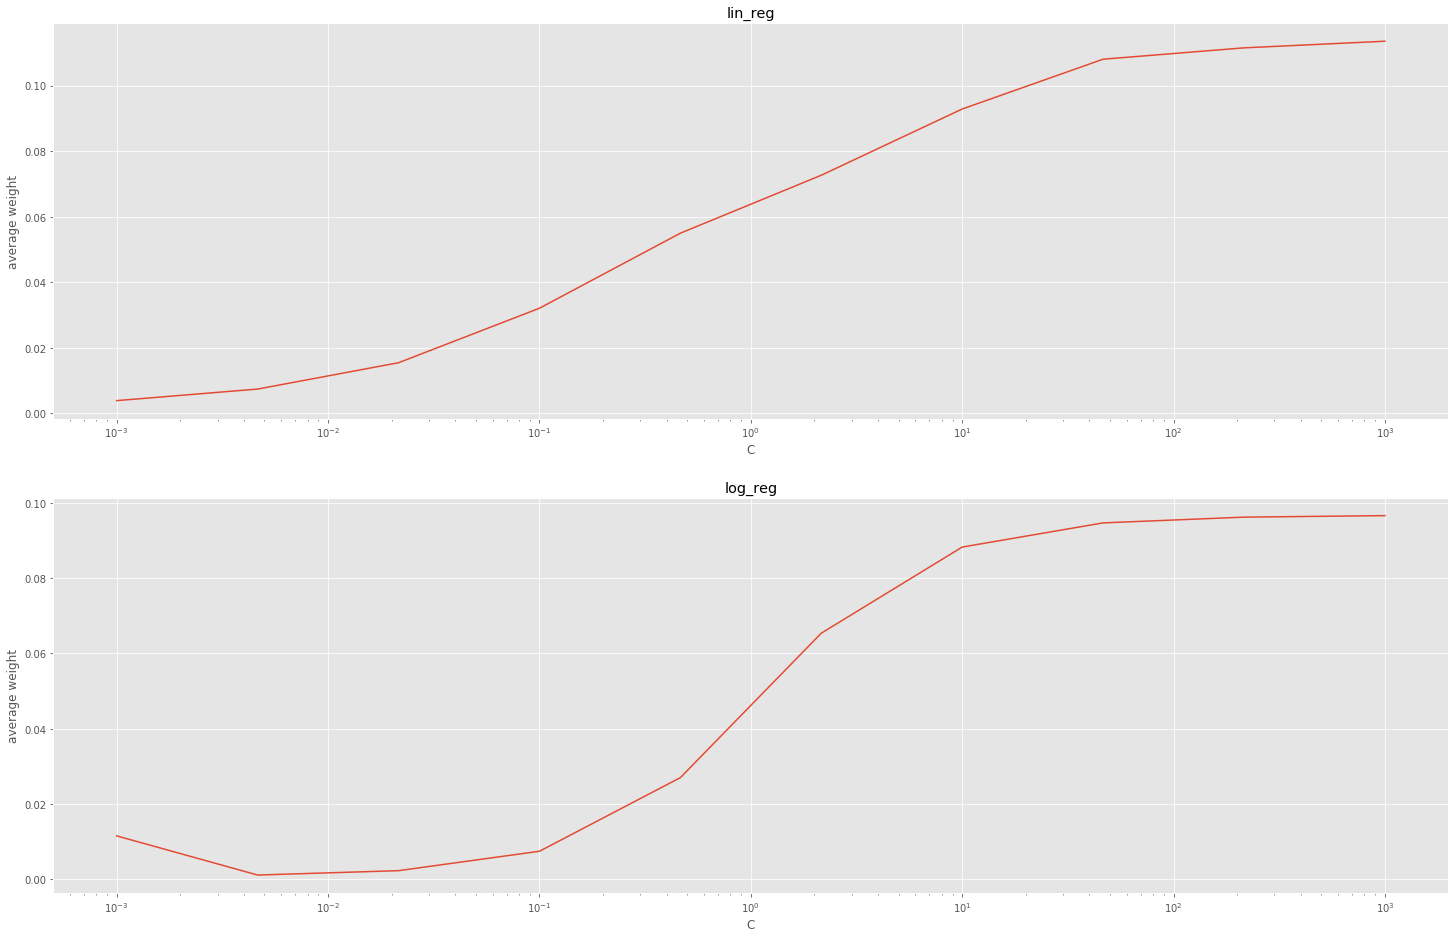

In [13]:
# %%pycodestyle

fig = plt.figure(figsize=(25, 16))

c_list = np.logspace(3, -3, 10)
average_weights_lin = []
average_weights_log = []
for C in c_list:
    print(C)
    clf = MySGDClassifier(batch_generator, C=C, max_epoch=1,
                          alpha=np.sqrt(C)/1000, model_type='lin_reg')
    clf.fit(X, y, batch_size=100)
    average_weights_lin.append(np.abs(clf.weights).mean())

    clf = MySGDClassifier(batch_generator, C=C, max_epoch=1,
                          alpha=0.001, model_type='log_reg')
    clf.fit(X, y, batch_size=100)
    average_weights_log.append(np.abs(clf.weights).mean())

fig.add_subplot(211, title="lin_reg",
                xlabel='C', ylabel='average weight',
                xscale='log')
plt.plot(c_list, average_weights_lin)

fig.add_subplot(212, title="log_reg",
                xlabel='C', ylabel='average weight',
                xscale='log')
plt.plot(c_list, average_weights_log)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [9]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [10]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [11]:
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15])
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print(X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [12]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [14]:
# %%pycodestyle

# Собираем индексы начала и конца каждой группы сайтов

prev_group = 1
prev_indx = 0
groups_indices = []
for k, i in zip_longest(range(len(groups_train) + 1),
                        groups_train, fillvalue=-1):
    if prev_group != i:
        groups_indices.append((prev_indx, k))
        prev_group = i
        prev_indx = k

In [16]:
# %%pycodestyle

from itertools import product

max_result = -1
c_list = np.logspace(-1, 2, 8)
alpha_list = (0.05, 0.01, 0.001, 0.0001, 0.00001)
max_epoch_list = (2, 5, 10, 15, 25, 50)

for (C, alpha, max_epoch) in product(c_list, alpha_list, max_epoch_list):
    result = 0.0
    for (a, b) in groups_indices:
        clf = MySGDClassifier(batch_generator, 
                              C=C, alpha=alpha, max_epoch=max_epoch, 
                              model_type='log_reg')
        clf.fit(X_train[b:a:-1], y_train[b:a:-1], batch_size=1000)
        result += f1_score(y_train[b:a:-1], clf.predict(X_train[b:a:-1]))
    result /= 129
    if result > max_result:
        max_result = result
        params = {'C': C, 'alpha': alpha, 'max_epoch': max_epoch}
print (max_result, params, sep='\n')

0.44216236020720856  
{'C': 0.1, 'alpha': 0.001, 'max_epoch': 15}


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [17]:
clf = MySGDClassifier(batch_generator, **params,
                      model_type='log_reg')
clf.fit(X_train, y_train, batch_size=1000)

MySGDClassifier(C=0.1, alpha=0.001,
                batch_generator=<function batch_generator at 0x7f4dd79c1cb0>,
                max_epoch=15, model_type='log_reg')

In [18]:
h_list = np.linspace(0.0, 1, 101)
result = np.zeros(len(h_list))
for i in range(len(h_list)):
    result[i] = f1_score(y_train, clf.predict(X_train, h_list[i]))
indx = result.argmax()
best_h = h_list[indx]
print(best_h, result[indx])

0.49 0.6112493777999005


С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук прислать Ваш ник на kaggle, под которым Вы залили решение, которое побило первый бейзлайн. **

In [19]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    pair_id = new_doc['pair_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, pair_id, title))
    
X_test = []
pairs_id = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, pair_id, title) in enumerate(docs):
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            *_, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
        pairs_id.append(pair_id)
X_test = np.array(X_test)
X_test = scaler.transform(X_test)
print(X_test.shape)

(16627, 15)


In [20]:
y_predict = clf.predict(X_test, best_h)

In [21]:
with open('predict.csv', 'w') as f:
    print('pair_id,target', file = f)
    for target, pair_id in zip(y_predict, pairs_id):
        print(pair_id, int(target), sep=',', file=f)

# Ник нэйм на Kaggle: Dima Andreev (просто dima на момент посылки)

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

В целом все ясно

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   